In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions, summarize_results
import utils.results as results
import torch
import torch.nn as nn
import os 

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

# os.environ['PATH'] += ':/Users/leonardamsler/bin'
# plt.style.use('ieee.mplstyle')
plt.rcdefaults()

## Loading and Preprocessing Data

### Loading Google Trends

In [2]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [3]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [4]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_high_freq = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="pct", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Simple Prediction Model

Using mps device


100%|██████████| 60/60 [00:01<00:00, 45.46it/s]


Final training loss: 0.10795918852090836
Final validation loss: 0.4985322952270508
Final validation R^2: 0.2966326683813221


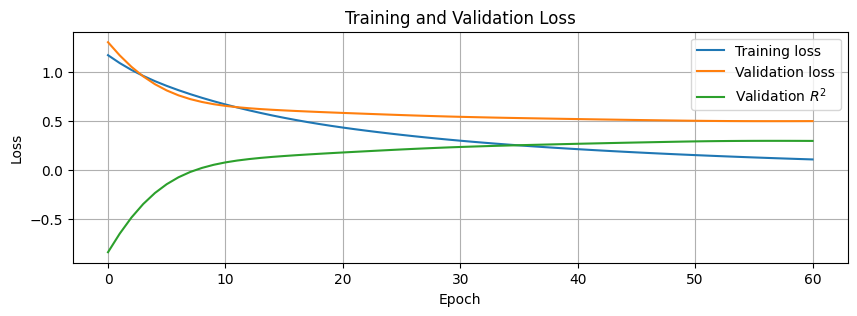

Best r squared: 0.29746126362594894 at epoch 57


In [5]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=60, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=5e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

# Compute best r squared with epoch
best_r_squared = max(validation_r_squared)
best_epoch = validation_r_squared.index(best_r_squared)

print(f"Best r squared: {best_r_squared} at epoch {best_epoch}")

## Ensembling

In [6]:
train_fn = lambda seed: train_nn(X_train, y_train, X_valid, y_valid, num_epochs=60, learning_rate=1e-4, weight_decay=5e-2, verbose=False, seed=seed)
results = bootstrap_ensemble(X_valid, y_valid, train_fn, n_ensembling=10, seed=SEED, device=get_device(False))

best_model = results['best_model']
y_pred_best = results['y_pred_best']
y_pred_mean = results['y_pred_mean']
y_pred_std = results['y_pred_std']
y_pred_median = results['y_pred_median']
best_rsquared = results['best_rsquared']
mse_ensemble = results['mse_ensemble']
rsquared_ensemble = results['rsquared_ensemble']
mape_ensemble = results['mape_ensemble']

Bootstrapping Ensembling: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Ensemble R2: 0.2626812827657693
Ensemble MSE: 0.522596328344839
Ensemble MAPE: 99.62689047677729
Ensemble R2: 0.2626812827657693
Ensemble MSE: 0.522596328344839
Ensemble MAPE: 99.62689047677729


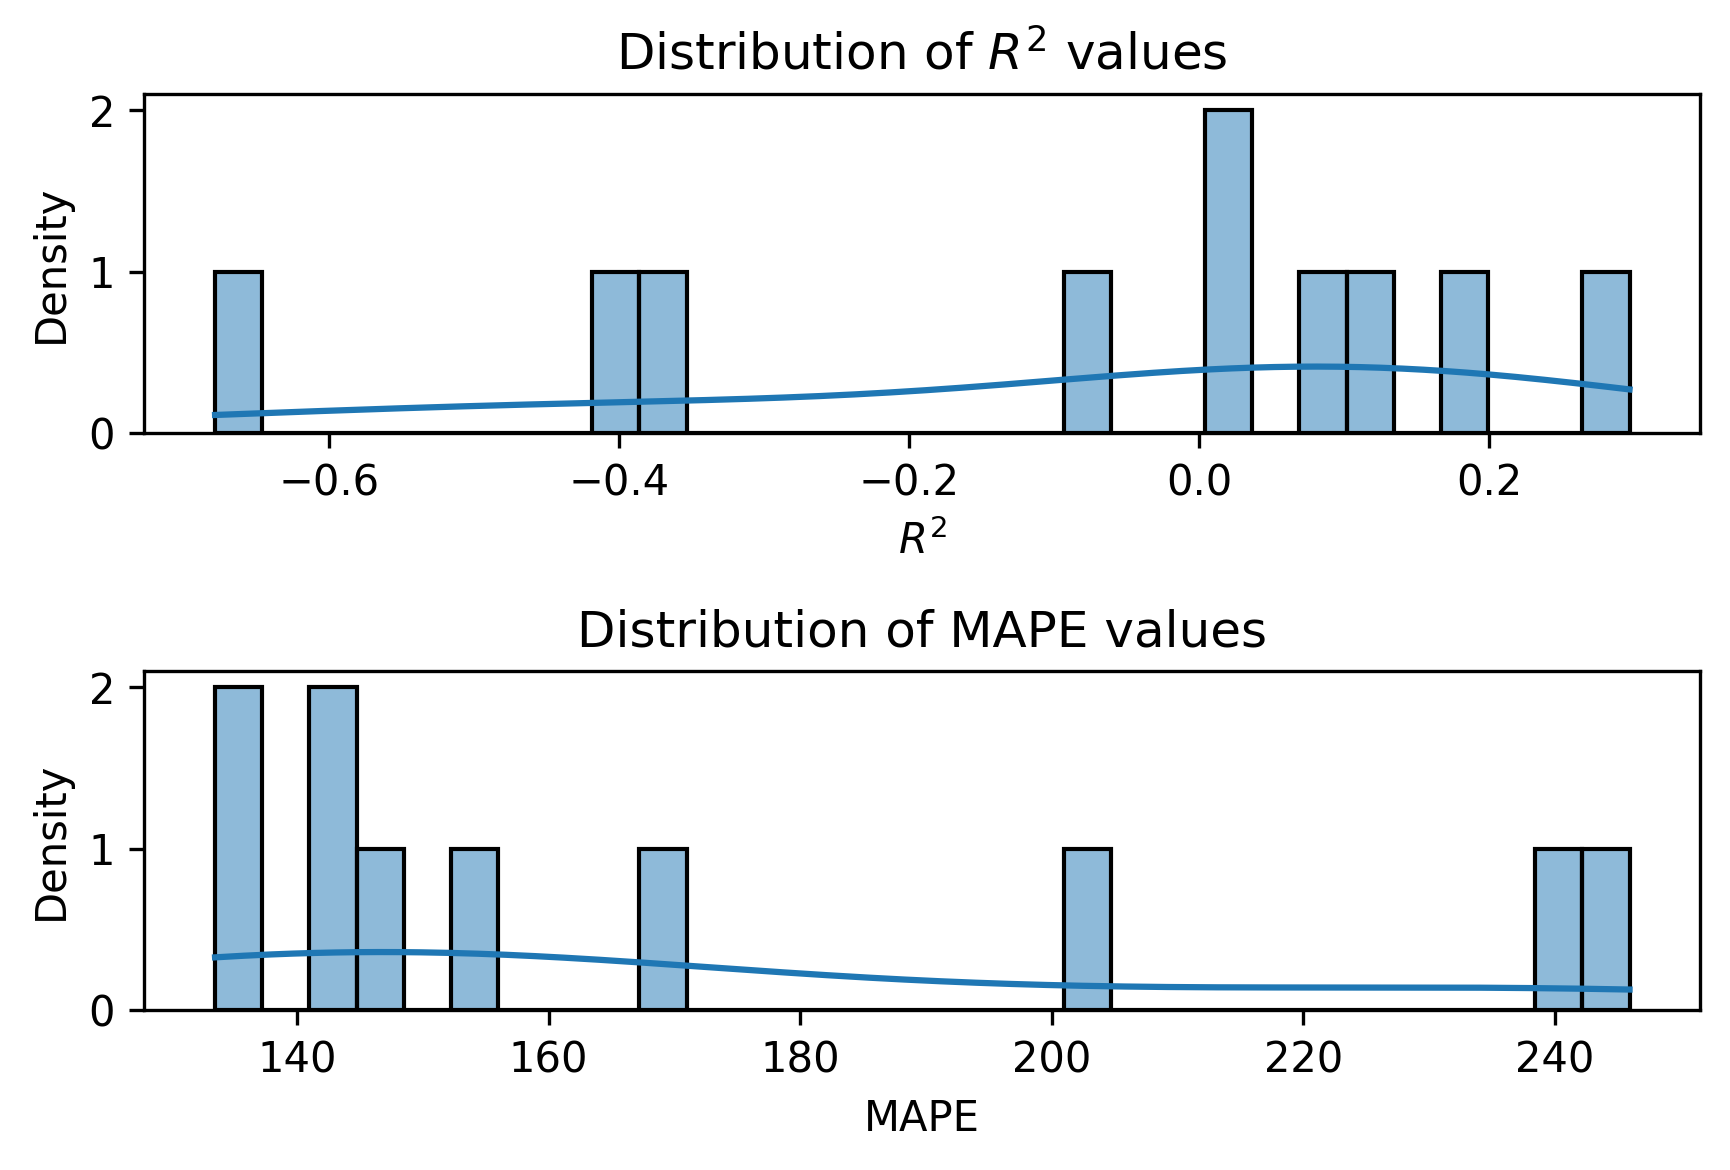

In [7]:
plt.figure(figsize=(6, 4), dpi=300)
plt.subplot(2,1,1)
summarize_results(y_valid, y_pred_mean, rsquared_ensemble, metric_name='$R^2$')
plt.subplot(2,1,2)
summarize_results(y_valid, y_pred_mean, mape_ensemble, metric_name='MAPE')
plt.tight_layout()
plt.show()

In [8]:
interactive_plot_predictions(
    country_valid=preprocessor.country_valid,
    y_valid=y_valid,
    y_pred_mean=y_pred_mean,
    y_pred_median=y_pred_median,
    y_pred_best=y_pred_best,
    y_pred_std=y_pred_std,
    title_prefix="GDP Prediction: "
)

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

In [9]:
device = get_device(False)

# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [10]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [11]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [12]:
import utils.results as results

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6), dpi=300)
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Low frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"{results.OUTPUT_DATA_PATH}/{selected_country}_low_frequency_predictions.png")
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

## High frequency predictions

In [13]:
# Predict for the high frequency data
y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})

In [14]:
# Get the true GDPs
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid
all_true_gdps_country = np.concatenate([y_train, y_valid], axis=0)
all_dates = pd.concat([preprocessor.dates_train, preprocessor.dates_valid], axis=0)
all_true_gdps_country = pd.DataFrame({'date': all_dates, 'country': np.concatenate([country_train, country_valid], axis=0), 'y_true': np.concatenate([y_train, y_valid], axis=0)})

In [15]:
# Set the predicions to be plotted
predictions = y_pred_high_freq_country

# Add the true gdp for the points that we have
predictions = predictions.merge(all_true_gdps_country, on=["date", "country"], how="left")

# Rename y_pred to y_pred_high_freq
predictions = predictions.rename(columns={"y_pred": "y_pred_high_freq"})

In [16]:
# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    #plt.fill_between(filtered_data["date"], filtered_data["y_pred_high_freq"] - 3 * filtered_data["stdv"], filtered_data["y_pred_high_freq"] + 3 * filtered_data["stdv"], alpha=0.2, color="blue")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
countries.sort()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…